# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 10:  Feed Forward Neural Networks:  Regularization and Adam optimizer

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Henry Jin, Hayden Joy

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In this section is we will learn methods for improving the network optimization. Essentially, the goal is to become familiar with regularization methods and with the optimizers used in training neural networks (NNs).

Specifically, we will: 
  
1. Use NNs to solve a regression task where polynomial regression fails
2. Fit noise data and observe underfitting and overfitting
3. Learn about early-stopping and regularization:  $L_1$, $L_2$, and  dropout
4. Explore the Adam optimizer
5. Improve the classifier network used in section 9


#### Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.preprocessing import PolynomialFeatures


import copy
import operator

from numpy.random import seed
seed(123)


In [3]:
tf.random.set_seed(256)

#### Helper functions: 
1. For plotting train set, test set, neural network predictions
2. For plotting the training and validation loss functions

In [4]:
def array_exists(arr):
        return hasattr(arr, 'shape')
#check if the numpy array exists

def reshape_if_exists(arr):
    if array_exists(arr):
        return arr['x'].values.reshape(-1,1), arr['y'].values.reshape(-1,1)
    else:
        return None, None
    
def reshape_and_extract_sets(train_set, test_set):
    """
    Extracts x_train, y_train, x_test and y_test and reshapes them for using with keras.
    """    
    x_train, y_train = reshape_if_exists(train_set)
    x_test, y_test   = reshape_if_exists(test_set)
    return x_train, y_train, x_test, y_test

def plot_sets(train_set = None, 
              test_set = None, 
              NN_model = None,
              title = None):
    """
    plots the train set, test set, and Neural network model's predictions if entered
    
    Arguments:
        train_set : The training set points to plot
        test_set  : The test set points to plot
        NN_model  : if you enter a model this function will plot the predictions
        title     : if you enter a title, it will display on the plot.
    """
    x_train, y_train, x_test, y_test = reshape_and_extract_sets(train_set, test_set)
    
    plt.figure(figsize = (12,5))
    if array_exists(train_set):
        plt.plot(x_train, y_train,'og', alpha = 0.8, label='train data')
        
    if array_exists(test_set):
        plt.plot(x_test, y_test,'^r', alpha = 0.8, label='test data')
        
    # if the neural network model was provided, plot the predictions.
    if type(NN_model) != type(None):
        xx = np.linspace(np.min(x_train), np.max(x_train), num = 1000)
        NN_preds = NN_model.predict(xx.reshape(-1,1)) 
        plt.plot(xx, NN_preds,'-b',linewidth=2,label='FFNN', alpha = 0.7)
        NN_preds_test = NN_model.predict(x_test.reshape(-1,1)) 
        r2 = r2_score(NN_preds_test, y_test)
        
    if title:
        if NN_model:
            plt.title(title + ", $R^2$ score ={}".format(round(r2,4)))
        else:
            plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.legend()
    
    if title:
        if "Lorentz" in title or "lorentz" in title:
            lorentz_labels()
    plt.show()
    
def plot_loss(model_history, rolling = None, title = "Loss vs Epoch "):
    """
    Arguments:
        model_history : the nueral network model history to plot
        title   : if you want a title other than the default plot it.
        rolling : this will plot a rolling average of the loss (purely for visualization purposes)
    """
    plt.figure(figsize = (12,5))
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    set_colors = {"train": sns.color_palette()[0],
                 "val": sns.color_palette()[1]}
    
    if rolling:
        alphas = [0.45, 0.35]
    else:
        alphas = [0.8, 0.6]
    
    plt.loglog( train_loss, linewidth=3, label = 'Training', alpha = alphas[0], color = set_colors["train"])
    
    plt.loglog( val_loss, linewidth=3, label = 'Validation', color = set_colors["val"], alpha=alphas[1])
    
    if rolling:
        plt.plot(pd.Series(train_loss).rolling(rolling).mean(),linewidth=4, 
                 label = 'Train loss rolling avg.', color = set_colors["train"])
        plt.plot(pd.Series(val_loss).rolling(rolling).mean(),linewidth=4, 
                 label = 'Val loss rolling avg.', color = set_colors["val"])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def lorentz_labels():
    """
    chage axis labels and set ylim for lorentz problem.
    """
    plt.xlabel('$\omega$')
    plt.ylabel('$\epsilon$')
    plt.legend()
    plt.ylim([-9,9]);

---------
## 1. Regression: Neural Nets VS Polynomial Regression

Let's fit a difficult function where polynomial regression fails. 

The dielectric function of many optical materials depends on the frequency and is given by the Lorentz model as:
$$ \varepsilon(\omega) = 1 - \frac{\omega_0^2}{\omega_0^2-\omega^2 +i\omega\Gamma},$$
where $\omega$ is the frequency, $\omega_0$ is the resonance frequency of the bound electrons, and $\Gamma$ is the electron damping. 

In many situations, we measure the real part of the dielectric function in the lab and then we fit these observations. Let's assume that we perform an experiment and the observations came from a Lorentz model. 

#### Lorentz model

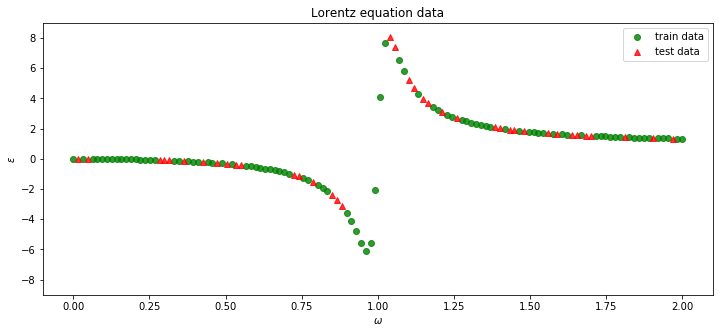

In [5]:
lor_set = pd.read_csv('../data/lorentz_set.csv')

lor_train, lor_test = train_test_split(lor_set, train_size=0.7, random_state=109)
x_train, y_train, x_test, y_test = reshape_and_extract_sets(lor_train, lor_test)

plot_sets(lor_train, lor_test, title = "Lorentz equation data")

In [6]:
x_train[:,0].shape

(89,)

### Using polynomial regression to fit the data

MSE on training set:  1.1882431815719614
MSE on testing set:  1.6884109651402155


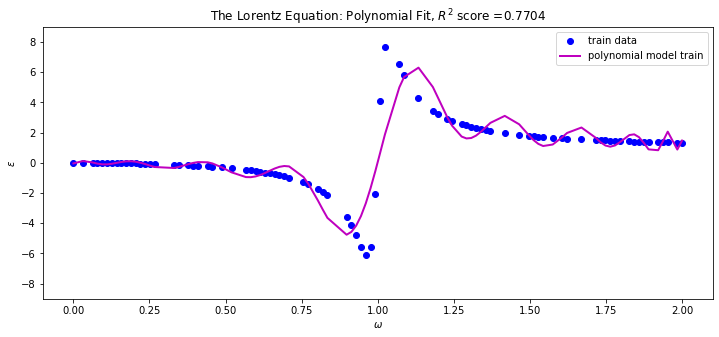

In [7]:
x = copy.copy(x_train)
y = copy.copy(y_train)
xTest = copy.copy(x_test)
yTest = copy.copy(y_test)


polynomial_features= PolynomialFeatures(degree=25)
x_poly = polynomial_features.fit_transform(x)
x_poly_test = polynomial_features.fit_transform(xTest)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_train = model.predict(x_poly)
y_poly_test = model.predict(x_poly_test)


mse_train_poly = mean_squared_error(y,y_poly_train)
mse_test_poly = mean_squared_error(yTest,y_poly_test)
print('MSE on training set: ', mse_train_poly)
print('MSE on testing set: ', mse_test_poly)
y_poly_pred = model.predict(x_poly)
plt.figure(figsize = (12,5))

plt.plot(x,y,'ob',label='train data')

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_train), key=sort_axis)
x, y_poly_train = zip(*sorted_zip)
plt.plot(x, y_poly_train, color='m',linewidth=2,label='polynomial model train')
plt.title("The Lorentz Equation: Polynomial Fit, $R^2$ score ={}".format(round(r2_score(y,y_poly_pred),4)))
lorentz_labels()

### Using a Neural Network

#### Design the Network

In [8]:
model_1 = models.Sequential(name='LorentzModel')

# hidden layer 
model_1.add(layers.Dense(50, activation='tanh', input_shape=(1,)))
#second hidden layer
model_1.add(layers.Dense(50, activation='tanh'))

# output layer, one neuron 
model_1.add(layers.Dense(1,  activation='linear'))

model_1.summary()

Model: "LorentzModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


#### Select a solver and train the NN

In [9]:
%%time

# optimizer = optimizers.SGD(lr=0.01, momentum=0.9)
optimizer = optimizers.Adam(lr=0.01) 


model_1.compile(loss='MSE',optimizer=optimizer) 
history_1 = model_1.fit(x_train, y_train,
                        validation_data=(x_test,y_test), 
                        epochs=1000, batch_size= 32,
                        verbose=0) 

CPU times: user 35.4 s, sys: 1.91 s, total: 37.3 s
Wall time: 36.5 s


#### Plot the training and validation loss

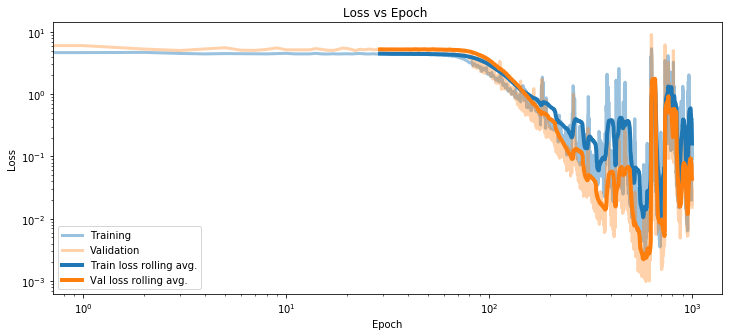

In [10]:
# Use the helper function
plot_loss(history_1, rolling = 30)

#### Visualize the model prediction

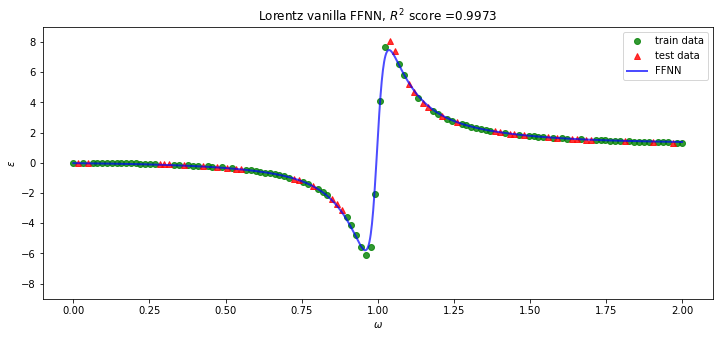

In [11]:
# Use the helper function
plot_sets(lor_train, lor_test, NN_model = model_1, 
          title = "Lorentz vanilla FFNN")

## 2. Noisy data, underfitting and overfitting

### In real-data always contain some noise
Hence, in a real experiment, the  observations will follow a form of
$$ \varepsilon(\omega) = 1 - \frac{\omega_0^2}{\omega_0^2-\omega^2 +i\omega\Gamma} + \epsilon,$$ 
where, $\epsilon$ is Gaussian (white) noise. 

Our goal is to discover the underlying law, namely the Lorentz model, by using neural networks.

Read, split, and plot the data:

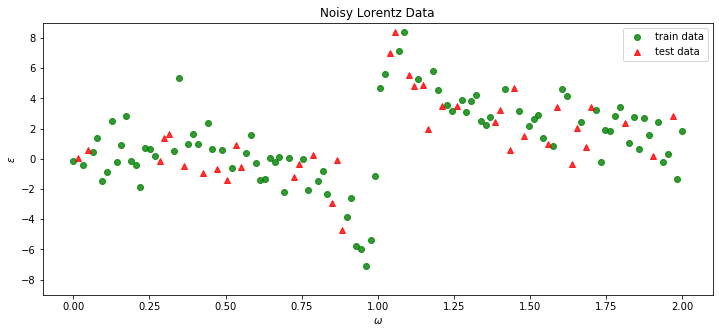

In [62]:
lor_set_n = pd.read_csv('../data/lorentz_noise_set2.csv')

lor_train_n, lor_test_n = train_test_split(lor_set_n, 
                                           train_size=0.7, 
                                           random_state=109)

x_train, y_train, x_test, y_test = reshape_and_extract_sets(lor_train_n, lor_test_n)

plot_sets(lor_train_n, lor_test_n,  title = "Noisy Lorentz Data")

### Discover the underlying function

#### Define some hyperparameter

In [13]:
n_neurons = 50
optimizer = optimizers.Adam(lr=0.01) 

In [14]:
model_2 = models.Sequential(name='noiseLorentzModel')

# first hidden layer 
model_2.add(layers.Dense(n_neurons, activation='tanh',
                         kernel_initializer='random_normal', 
                         bias_initializer='random_normal', 
                         input_shape=(1,)))
# second hidden layer 
model_2.add(layers.Dense(n_neurons, activation='tanh'))

# output layer, one neuron 
model_2.add(layers.Dense(1,  activation='linear'))

model_2.summary()

Model: "noiseLorentzModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time
model_2.compile(loss='MSE', optimizer=optimizer) 

history_2 = model_2.fit(x_train, y_train,
            validation_data=(x_test,y_test), epochs=500, batch_size= 32, verbose=0) 

CPU times: user 18.8 s, sys: 1.01 s, total: 19.8 s
Wall time: 19.3 s


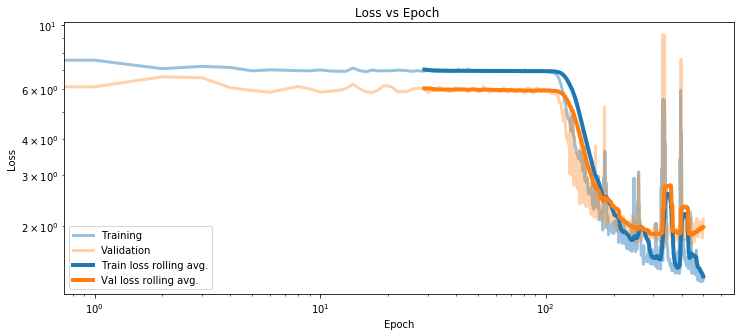

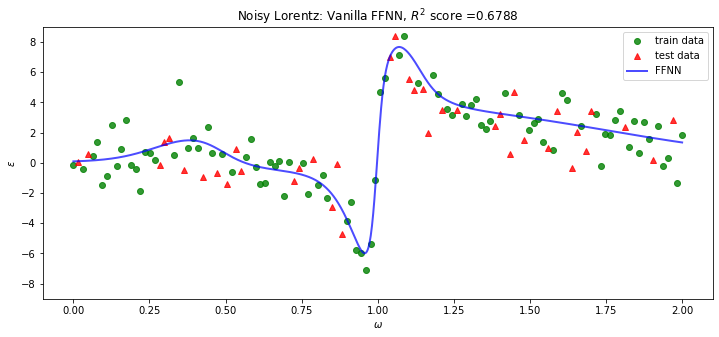

In [16]:
plot_loss(history_2, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2, 
          title = "Noisy Lorentz: Vanilla FFNN"
          )

### Underfitting
We use the same architecture but we train less

In [17]:
%%time
model_2_uf = models.Sequential(name='noiseLorentzModel_underFitting')

# first hidden layer 
model_2_uf.add(layers.Dense(n_neurons, activation='tanh', 
                            kernel_initializer='random_normal', bias_initializer='random_normal', 
                            input_shape=(1,)))
# second hidden layer 
model_2_uf.add(layers.Dense(n_neurons, activation='tanh'))

# output layer, one neuron 
model_2_uf.add(layers.Dense(1,  activation='linear'))

model_2_uf.compile(loss='MSE',optimizer=optimizer) 
history_2_uf = model_2_uf.fit(x_train, y_train,
            validation_data=(x_test,y_test), epochs=80,
                              batch_size= 32, verbose=0) 

CPU times: user 4.1 s, sys: 181 ms, total: 4.28 s
Wall time: 4.2 s


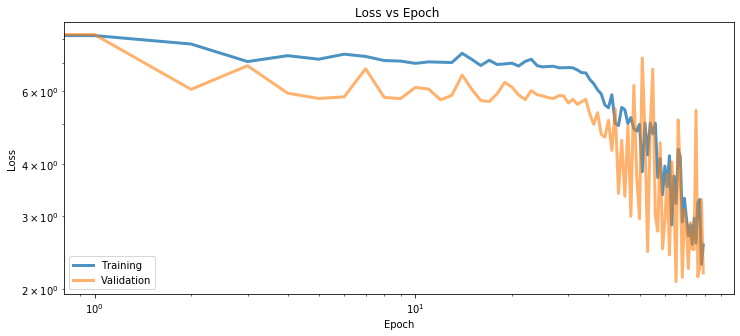

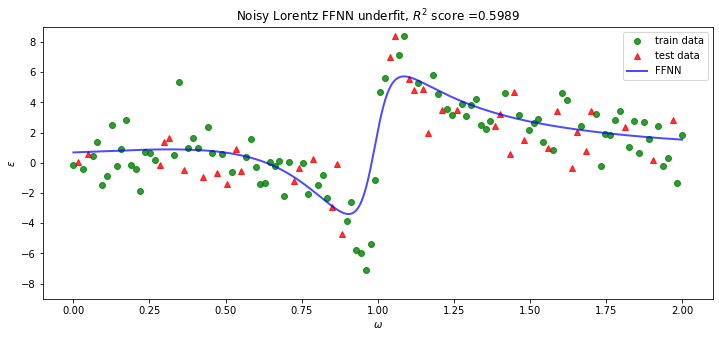

In [18]:
plot_loss(history_2_uf)

plot_sets(lor_train_n, lor_test_n, NN_model = model_2_uf,
         title = "Noisy Lorentz FFNN underfit")

### Overfitting
Train for long time. 

Change a hyperparameter:

In [19]:
epochs_max = 2000

In [20]:
model_2_of = models.Sequential(name='noiseLorentzModel_overFitting')

# first hidden layer 
model_2_of.add(layers.Dense(n_neurons, activation='tanh',
                            kernel_initializer='random_normal', 
                            bias_initializer='random_normal', 
                            input_shape=(1,)))
# second hidden layer 
model_2_of.add(layers.Dense(n_neurons, activation='tanh'))

# output layer, one neuron 
model_2_of.add(layers.Dense(1,  activation='linear'))

model_2_of.compile(loss='MSE', optimizer=optimizer) 


In [21]:
%%time
history_2_of = model_2_of.fit(x_train, y_train,
            validation_data=(x_test,y_test), epochs=epochs_max, 
            batch_size= 32, verbose=0) 

CPU times: user 1min 10s, sys: 3.72 s, total: 1min 13s
Wall time: 1min 13s


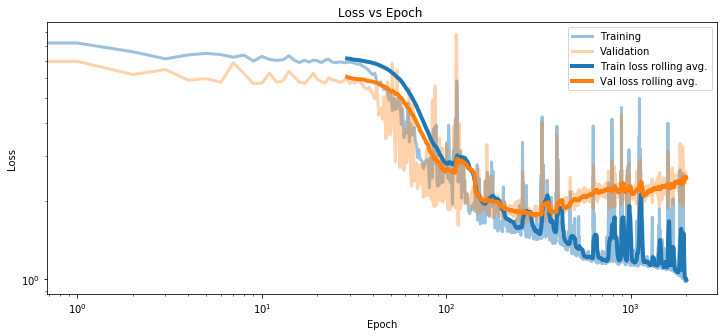

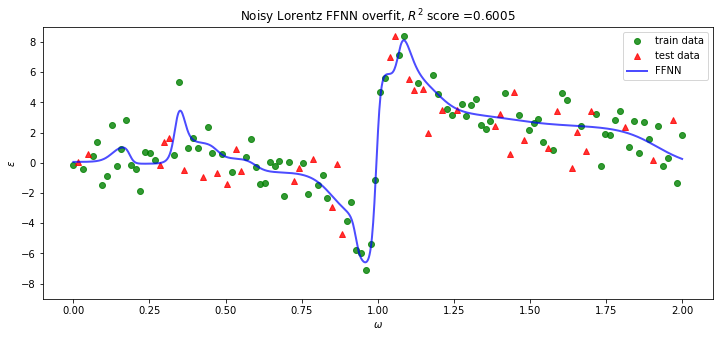

In [22]:
plot_loss(history_2_of, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_of, title = "Noisy Lorentz FFNN overfit")

## Regularization

The easiest way to avoid overfitting is the **early-stopping** method, namely stop the training when the validation loss is minimum. A more systematic method is given by **regularization**.

*Early-stopping  does not change the model* but *regularization does change the model* since we change the loss function.

  Two common regularization methods are the so-called $L_1$ and $L_2$. 
- $L_1$ tries to minimize the number of network parameters and *reduces the model complexity*. In other words, it is trying to have as many zero parameters as it is possible. $L_1$ **wants the smallest number of parameters**. 
- $L_2$ tries to minimize the value of all the parameters and gives a more stable network. So, it does not care about the number of the non-zero  parameters but it cares about their values. $L_2$ **wants the smallest values of parameters**.


Warning! In the extreme limit of too large regularization coefficients both $L_1$ and $L_2$ lead to zero parameters. Over-regularization  yields  *underfitting*.

## Dropout

Another method of regularizing a neural network is called 'dropout'. In dropout, we randomly 'drop' some neurons of the neural network with probability *p* during training. This forces the network to distribute the weights across its neurons, preventing it from becoming overly dependent on any particular subset of neurons. 

### Early stopping

In [23]:
%%time

callback = callbacks.EarlyStopping(monitor='val_loss', patience=55)
model_2_estop = models.Sequential(name='noiseLorentzModel_earlyStopping')

# first hidden layer 
model_2_estop.add(layers.Dense(n_neurons, activation='tanh',
                            kernel_initializer='random_normal', 
                            bias_initializer='random_normal', 
                            input_shape=(1,)))
# second hidden layer 
model_2_estop.add(layers.Dense(n_neurons, activation='tanh'))

# output layer, one neuron 
model_2_estop.add(layers.Dense(1,  activation='linear'))

model_2_estop.compile(loss='MSE',optimizer=optimizer) 


history_2_estop = model_2_estop.fit(x_train, y_train,
            validation_data=(x_test, y_test), epochs=epochs_max, callbacks = [callback],
            batch_size= 32, verbose=0) 



CPU times: user 9.34 s, sys: 389 ms, total: 9.73 s
Wall time: 9.29 s


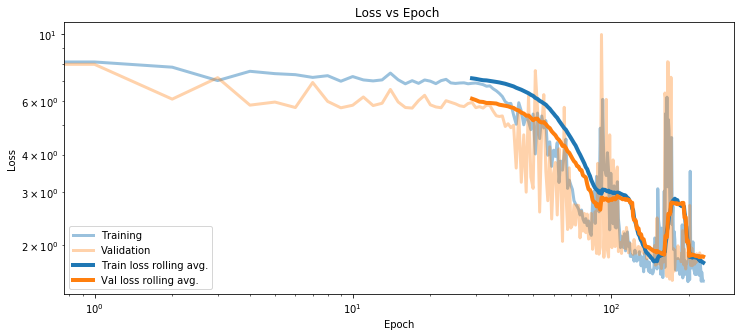

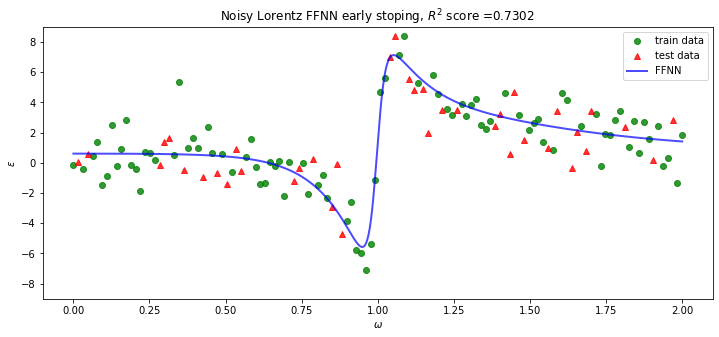

In [24]:
plot_loss(history_2_estop, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_estop, title = "Noisy Lorentz FFNN early stoping")

### $L_1$ Regularizer

In [25]:
kernel_weight = 0.005
bias_weight = 0.005

model_2_l1 = models.Sequential(name='noiseLorentzModel_l1')
# first hidden layer 
model_2_l1.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', 
                            bias_initializer='random_normal', 
                kernel_regularizer=regularizers.l1(kernel_weight),
                            bias_regularizer=regularizers.l1(bias_weight) ))

# second hidden layer 
model_2_l1.add(layers.Dense(n_neurons, activation='tanh', 
                kernel_regularizer= regularizers.l1(kernel_weight)))

# output layer, one neuron 
model_2_l1.add(layers.Dense(1,  activation='linear'))


In [26]:
%%time
model_2_l1.compile(loss='MSE',optimizer=optimizer) 

history_2_l1 = model_2_l1.fit(x_train, y_train,
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= 32, verbose=0) 

CPU times: user 1min 14s, sys: 3.97 s, total: 1min 18s
Wall time: 1min 16s


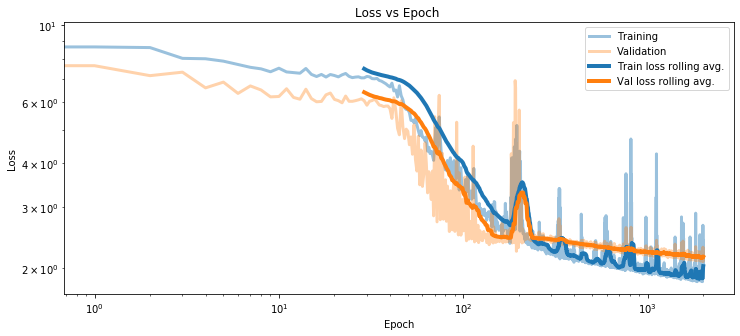

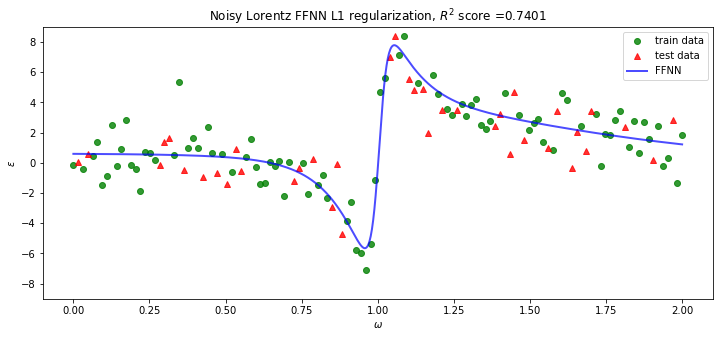

In [27]:
plot_loss(history_2_l1, rolling = 30)
l1_args = {"NN_model" : model_2_l1, 
           "title" : "Noisy Lorentz FFNN L1 regularization"}
plot_sets(lor_train_n, lor_test_n, **l1_args)

### $L_2$ Regularizer

In [28]:
kernel_weight = 0.005
bias_weight = 0.005

model_2_l2 = models.Sequential(name='noiseLorentzModel_l2')
# first hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', bias_initializer='random_normal', 
                kernel_regularizer=regularizers.l2(kernel_weight),
                bias_regularizer=regularizers.l2(bias_weight) ))

# second hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', 
                kernel_regularizer= regularizers.l2(kernel_weight)))

# output layer, one neuron 
model_2_l2.add(layers.Dense(1,  activation='linear'))

In [29]:
%%time

model_2_l2.compile(loss='MSE',optimizer=optimizer) 

history_2_l2 = model_2_l2.fit(x_train, y_train, 
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= 32, verbose=0) 

CPU times: user 1min 16s, sys: 4.27 s, total: 1min 20s
Wall time: 1min 20s


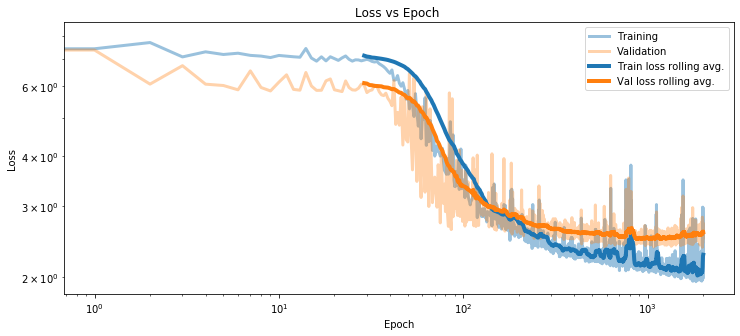

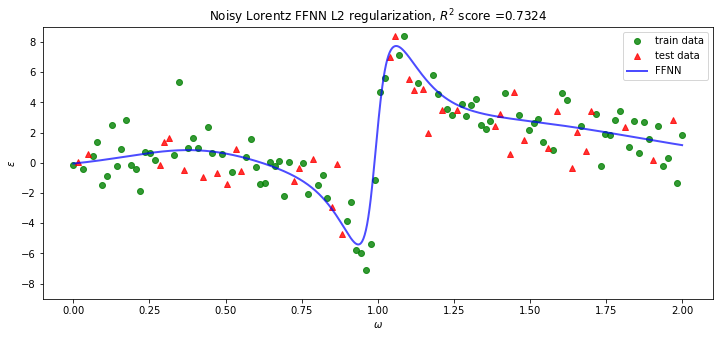

In [30]:
plot_loss(history_2_l2, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_l2, title = "Noisy Lorentz FFNN L2 regularization")

### Regularizing with Dropout



In [31]:
kernel_weight = 0.005
bias_weight = 0.005

model_drop = models.Sequential(name='noiseLorentzModel_drop')


model_drop.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', bias_initializer='random_normal',
                  kernel_regularizer=regularizers.l1(kernel_weight),
                  bias_regularizer=regularizers.l1(bias_weight) 
                           ))
# dropout for first hidden layer
model_drop.add(layers.Dropout(0.3))
# hidden layer 
model_drop.add(layers.Dense(n_neurons, activation='tanh', 
                             kernel_regularizer=regularizers.l1(kernel_weight)
                           ))
                           

# output layer, one neuron 
model_drop.add(layers.Dense(1,  activation='linear'))


In [32]:
%%time
model_drop.compile(loss='MSE',optimizer=optimizer) 

history_drop = model_drop.fit(x_train, y_train,
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= 32, verbose=0) 

CPU times: user 1min 21s, sys: 4.39 s, total: 1min 26s
Wall time: 1min 26s


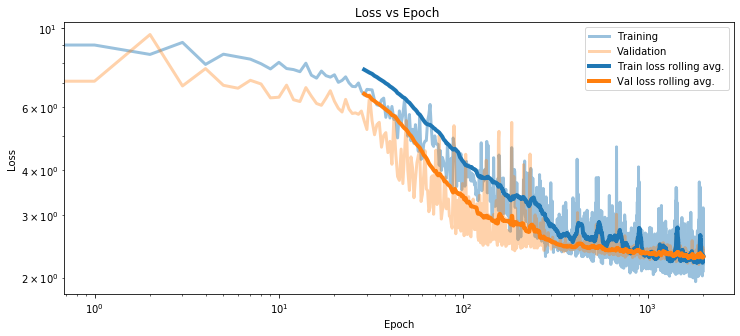

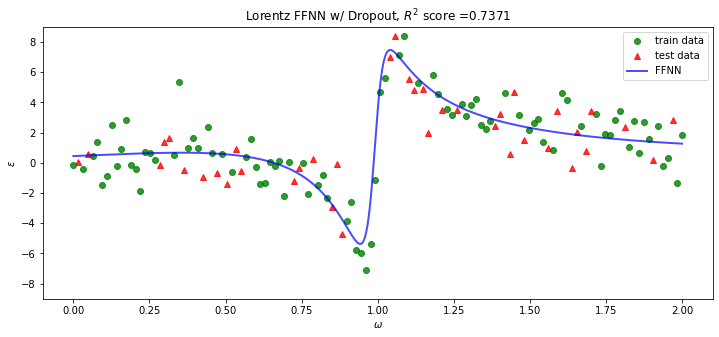

In [33]:
plot_loss(history_drop, rolling = 30)

plot_sets(lor_train_n, lor_test_n, NN_model = model_drop, title = "Lorentz FFNN w/ Dropout")

### Underfitting through Regularization

In [34]:
kernel_weight_Large = .1
bias_weight_Large = .1

model_2_l2_uf = models.Sequential(name='noiseLorentzModel_l2_uf')
# first hidden layer 
model_2_l2_uf.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', bias_initializer='random_normal', 
                kernel_regularizer=regularizers.l2(kernel_weight_Large),
                bias_regularizer=regularizers.l2(bias_weight_Large) ))

# second hidden layer 
model_2_l2_uf.add(layers.Dense(n_neurons, activation='tanh', 
                kernel_regularizer= regularizers.l2(kernel_weight_Large)))
# output layer, one neuron 
model_2_l2_uf.add(layers.Dense(1,  activation='linear'))


In [35]:
%%time
model_2_l2_uf.compile(loss='MSE',optimizer=optimizer) 

history_2_l2_uf = model_2_l2_uf.fit(x_train, y_train,
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= 32, verbose=0) 

CPU times: user 1min 18s, sys: 4.34 s, total: 1min 23s
Wall time: 1min 22s


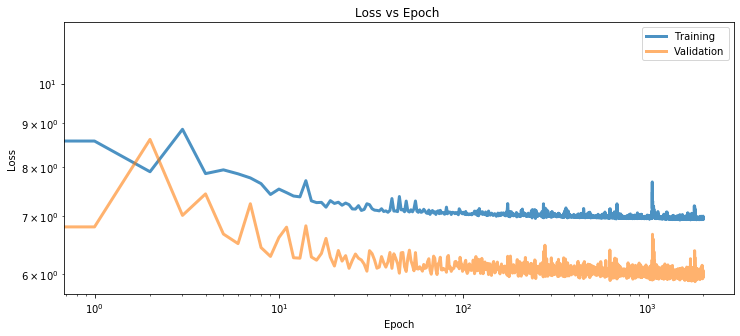

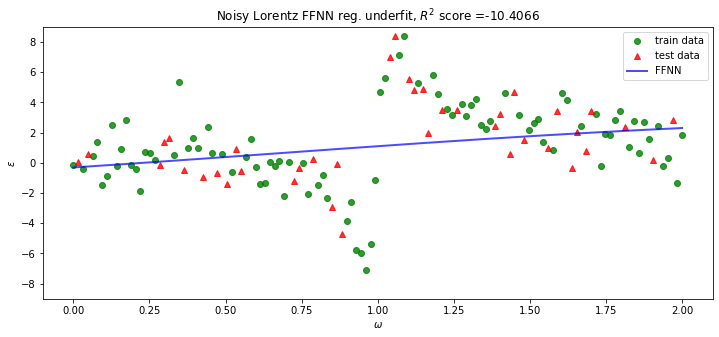

In [36]:
plot_loss(history_2_l2_uf)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_l2_uf,title = "Noisy Lorentz FFNN reg. underfit")

#### Inspect the weights

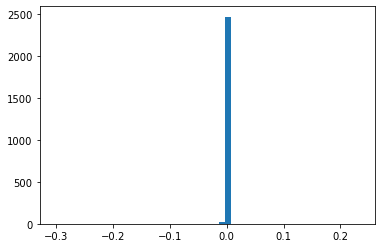

In [37]:
weights = model_2_l2_uf.layers[1].get_weights()[0]
plt.hist(weights.flatten(),bins=50);

# Break Out Room 1

#### Prevent the training from overfitting 
1. Overfit the given data below. 
2. Plot the loss for the overfit neural network 
3. Regularize all the layers of this model using either L1 or L2. Find a good set of regularization coefficients
4. Plot the losses for the regularized neural network 

Note: Use the functions we have declared above for plotting the loss and the neural network output

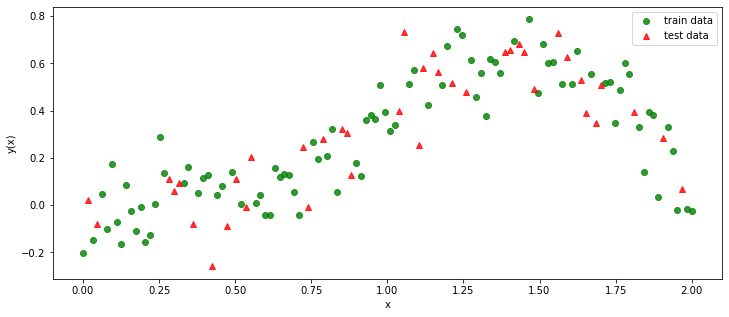

In [38]:
r1_set = pd.read_csv('../data/breakRoom1.csv')

r1_train, r1_test = train_test_split(r1_set, train_size=0.7, random_state=109)
x_train1, y_train1, x_test1, y_test1 = reshape_and_extract_sets(r1_train, r1_test)

plot_sets(r1_train, r1_test)

In [39]:
epochs_max1=2000
n_neurons1=50

model_br1 = models.Sequential(name='br1_overfit')

# first hidden layer 
model_br1.add(layers.Dense(n_neurons1, activation='tanh',
                            kernel_initializer='random_normal', bias_initializer='random_normal', 
                            input_shape=(1,)))
# second hidden layer 
model_br1.add(layers.Dense(n_neurons1, activation='tanh'))

# third hidden layer 
model_br1.add(layers.Dense(n_neurons1, activation='tanh'))

# output layer, one neuron 
model_br1.add(layers.Dense(1,  activation='linear'))

adam = optimizers.Adam(lr=0.01) 
model_br1.compile(loss='MSE',optimizer=adam) 


In [40]:
%%time
history_br1 = model_br1.fit(x_train1, y_train1,
            validation_data=(x_test1,y_test1), epochs=epochs_max1, batch_size= 32, verbose=0) 

CPU times: user 1min 21s, sys: 4.4 s, total: 1min 26s
Wall time: 1min 25s


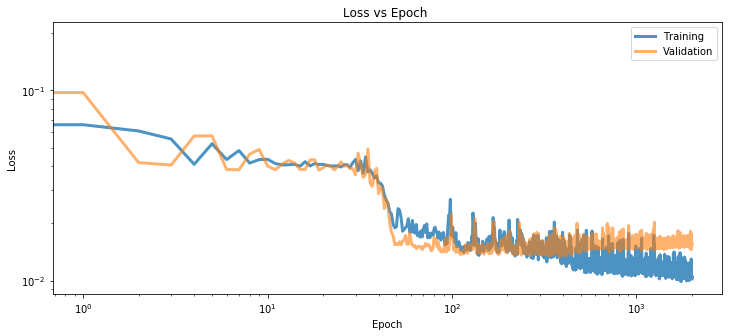

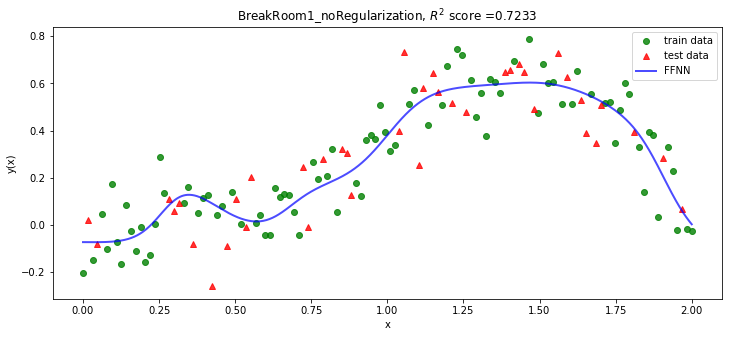

In [41]:
plot_loss(history_br1)
plot_sets(r1_train, r1_test, NN_model = model_br1, title = "BreakRoom1_noRegularization")

#### Regularize the network

In [42]:
## Your code here

In [15]:
# %load '../solutions/sol_1.py'


## Explore the Adam optimizer 
We explore method to improve the training. 

- Learning rate
- Momentum
- Number of minibatches


### Learning Rate

#### Baseline model

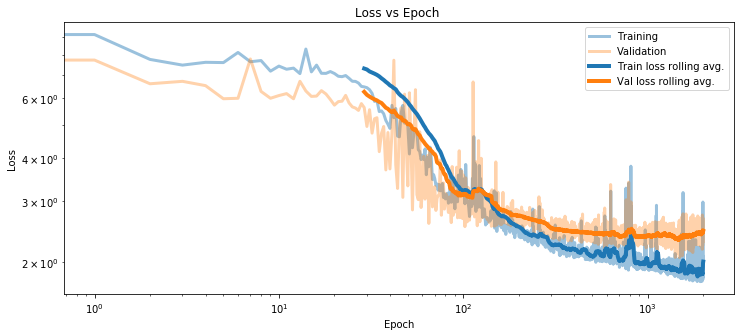

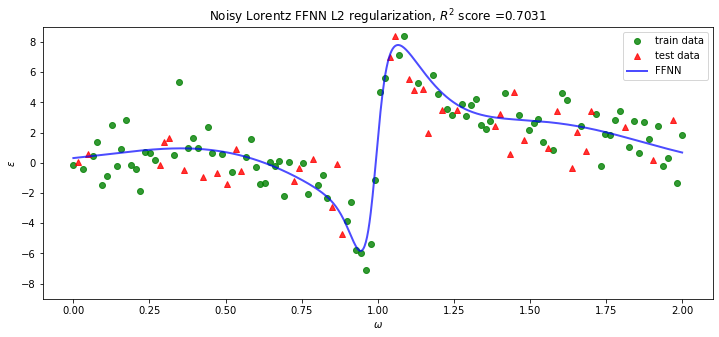

CPU times: user 1min 34s, sys: 5.07 s, total: 1min 40s
Wall time: 1min 45s


In [44]:
%%time

kernel_weight = 0.003
bias_weight = 0.003

model_2_l2 = models.Sequential(name='noiseLorentzModel_l2_baseline')
# first hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', bias_initializer='random_normal', 
                kernel_regularizer=regularizers.l2(kernel_weight),
                bias_regularizer=regularizers.l2(bias_weight) ))

# second hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', 
                kernel_regularizer= regularizers.l2(kernel_weight)))

# output layer, one neuron 
model_2_l2.add(layers.Dense(1,  activation='linear'))


model_2_l2.compile(loss='MSE',optimizer=optimizer) 

history_2_l2 = model_2_l2.fit(x_train, y_train, 
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= 32, verbose=0) 

plot_loss(history_2_l2, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_l2, title = "Noisy Lorentz FFNN L2 regularization")

#### Too large of a learning rate

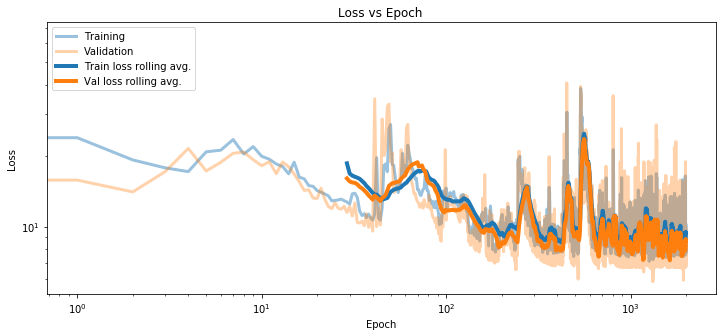

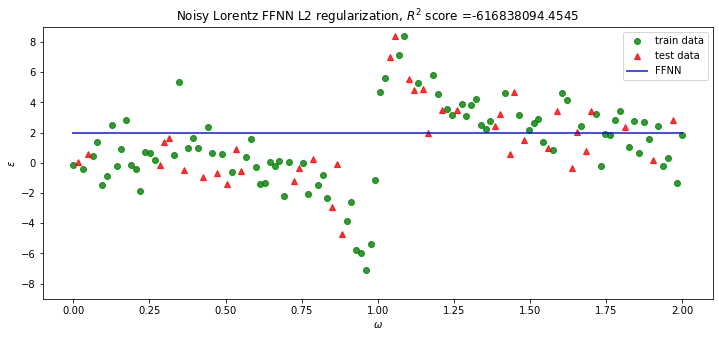

In [45]:
optimizer_large_lr = optimizers.Adam(lr=0.3) 

kernel_weight = 0.003
bias_weight = 0.003

model_2_l2 = models.Sequential(name='noiseLorentzModel_l2_large_lr')
# first hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', bias_initializer='random_normal', 
                kernel_regularizer=regularizers.l2(kernel_weight),
                bias_regularizer=regularizers.l2(bias_weight) ))

# second hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', 
                kernel_regularizer= regularizers.l2(kernel_weight)))

# output layer, one neuron 
model_2_l2.add(layers.Dense(1,  activation='linear'))


model_2_l2.compile(loss='MSE',optimizer=optimizer_large_lr) 

history_2_l2 = model_2_l2.fit(x_train, y_train, 
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= 32, verbose=0) 

plot_loss(history_2_l2, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_l2, title = "Noisy Lorentz FFNN L2 regularization")

#### Too small learning rate

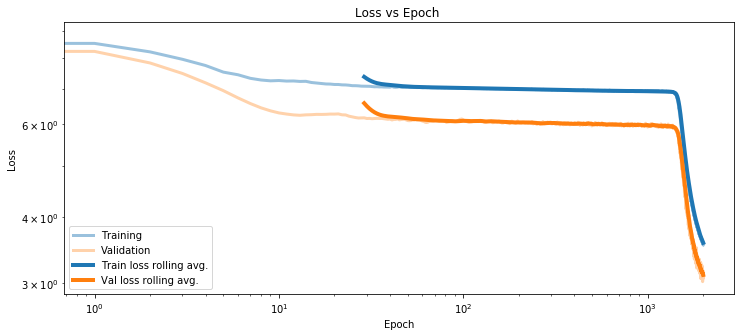

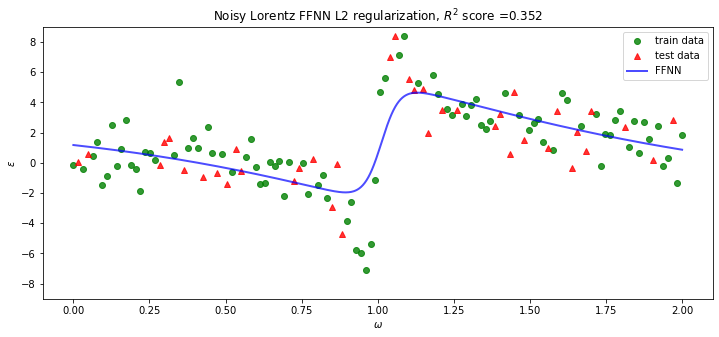

In [63]:
optimizer_small_lr = optimizers.Adam(lr=0.001)

kernel_weight = 0.003
bias_weight = 0.003

model_2_l2 = models.Sequential(name='noiseLorentzModel_l2_small_lr')
# first hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', bias_initializer='random_normal', 
                kernel_regularizer=regularizers.l2(kernel_weight),
                bias_regularizer=regularizers.l2(bias_weight) ))

# second hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', 
                kernel_regularizer= regularizers.l2(kernel_weight)))

# output layer, one neuron 
model_2_l2.add(layers.Dense(1,  activation='linear'))


model_2_l2.compile(loss='MSE',optimizer=optimizer_small_lr) 

history_2_l2 = model_2_l2.fit(x_train, y_train, 
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= 32, verbose=0) 

plot_loss(history_2_l2, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_l2, title = "Noisy Lorentz FFNN L2 regularization")

### Batching

#### Very large batch size

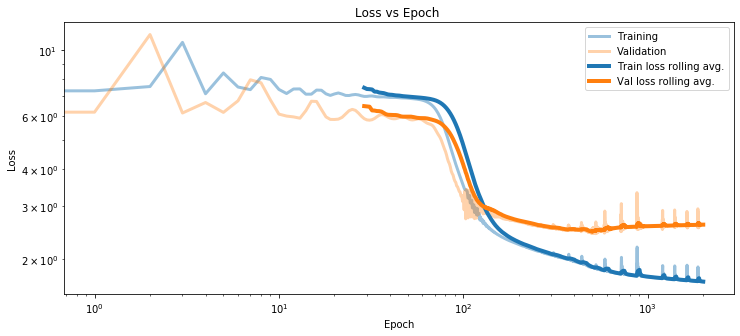

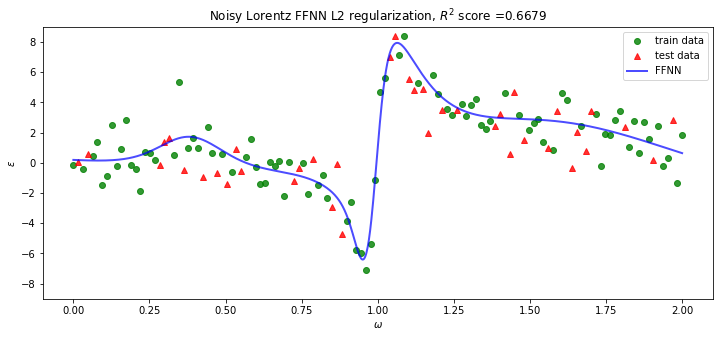

In [47]:
%%time
batch_size = lor_train.shape[0]

kernel_weight = 0.003
bias_weight = 0.003

model_2_l2 = models.Sequential(name='noiseLorentzModel_l2_large_batch')
# first hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', bias_initializer='random_normal', 
                kernel_regularizer=regularizers.l2(kernel_weight),
                bias_regularizer=regularizers.l2(bias_weight) ))

# second hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', 
                kernel_regularizer= regularizers.l2(kernel_weight)))

# output layer, one neuron 
model_2_l2.add(layers.Dense(1,  activation='linear'))


model_2_l2.compile(loss='MSE',optimizer=optimizer) 

history_2_l2 = model_2_l2.fit(x_train, y_train, 
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= batch_size, verbose=0) 

plot_loss(history_2_l2, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_l2, title = "Noisy Lorentz FFNN L2 regularization")

#### Very small batch size (too slow)
check the training time, it is more than 3 times slower than the network with batch size 32

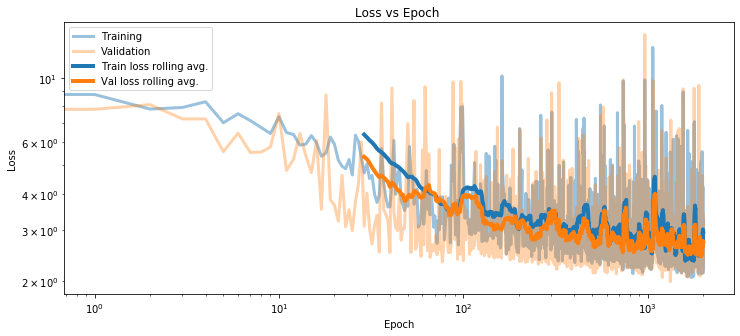

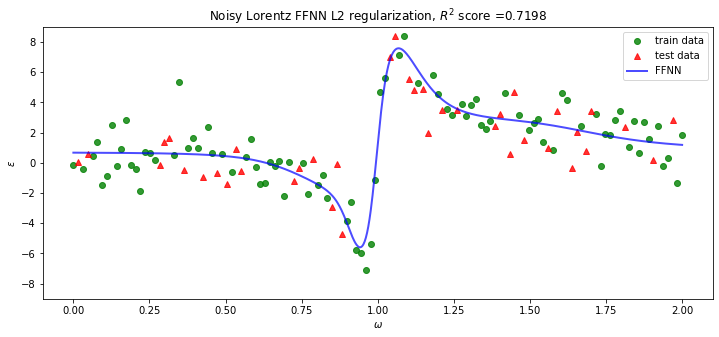

CPU times: user 4min 56s, sys: 18.4 s, total: 5min 14s
Wall time: 4min 44s


In [48]:
%%time
batch_size = 4

kernel_weight = 0.003
bias_weight = 0.003

model_2_l2 = models.Sequential(name='noiseLorentzModel_l2_large_batch')
# first hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', input_shape=(1,),
                kernel_initializer='random_normal', bias_initializer='random_normal', 
                kernel_regularizer=regularizers.l2(kernel_weight),
                bias_regularizer=regularizers.l2(bias_weight) ))

# second hidden layer 
model_2_l2.add(layers.Dense(n_neurons, activation='tanh', 
                kernel_regularizer= regularizers.l2(kernel_weight)))

# output layer, one neuron 
model_2_l2.add(layers.Dense(1,  activation='linear'))


model_2_l2.compile(loss='MSE',optimizer=optimizer) 

history_2_l2 = model_2_l2.fit(x_train, y_train, 
            validation_data=(x_test,y_test), epochs=epochs_max, batch_size= batch_size, verbose=0) 

plot_loss(history_2_l2, rolling = 30)
plot_sets(lor_train_n, lor_test_n, NN_model = model_2_l2, title = "Noisy Lorentz FFNN L2 regularization")

## Classification Task

#### Wine Dataset

Here, we will work with the wine dataset which we saw in Section 5. First, we overfit the data with a neural network.


In [5]:
def get_rolling_avg(arr, rolling = 10):
    return pd.Series(arr).rolling(rolling).mean()

def plot_accuracy_loss_rolling(model_history, rollNum=10):
    plt.figure(figsize=[12,4])
    plt.subplot(1,2,1)
    plt.semilogx(get_rolling_avg(model_history.history['accuracy'],rollNum), label = 'train_acc', linewidth=4)
    plt.semilogx(get_rolling_avg(model_history.history['val_accuracy'],rollNum), label = 'val_acc', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Rolling Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.loglog(get_rolling_avg(model_history.history['loss'],rollNum), label = 'train_loss', linewidth=4)
    plt.loglog(get_rolling_avg(model_history.history['val_loss'],rollNum), label = 'val_loss', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Rolling Loss')
    plt.legend()
    plt.show()
#     print('Accuracy in temodel_history.history['val_accuracy'][-1])

In [50]:
from sklearn.datasets import load_wine
dataset_wine = load_wine()
X_wine = pd.DataFrame(data=dataset_wine.data, columns=dataset_wine.feature_names)
y_wine = pd.DataFrame(data=dataset_wine.target, columns=['class'])
print(X_wine.shape)
print(y_wine.shape)
full_df_wine = pd.concat([X_wine, y_wine], axis=1)
full_df_wine.head()

(178, 13)
(178, 1)


alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  class  
0                          3.92   1065.0      0  
1                          3.40   1050.0      0  
2                          3.17   1185.0      0  
3                          3.45   1480.0      0  
4                          2.93    735.0      0

In [51]:
%%time
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, test_size=0.6, random_state=41)

model_wine_ofit = models.Sequential([
  layers.Input(shape = (13,)),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(3, activation = 'softmax')
])
model_wine_ofit.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(0.005),
    metrics=['accuracy'],
)
wine_trained_ofit = model_wine_ofit.fit(
    x = X_train_wine.to_numpy(), y = y_train_wine.to_numpy(), verbose=0,
    epochs=1000, validation_data= (X_test_wine.to_numpy(), y_test_wine.to_numpy()),
)


CPU times: user 43.1 s, sys: 2.48 s, total: 45.6 s
Wall time: 42.6 s


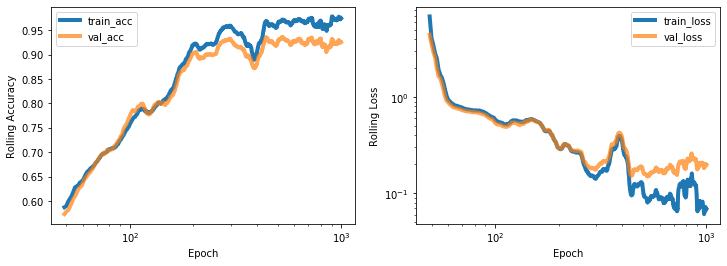

In [52]:
plot_accuracy_loss_rolling(wine_trained_ofit, rollNum=50)

#### Add L2 regularization

In [53]:
kernel_weight = 0.01
bias_weight = 0.01
model_wine_l2 = models.Sequential([
  layers.Input(shape = (13,)),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(kernel_weight), bias_regularizer=regularizers.l2(bias_weight)),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(kernel_weight), bias_regularizer=regularizers.l2(bias_weight)),
  layers.Dense(3, activation = 'softmax')
])
model_wine_l2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(0.005),
    metrics=['accuracy'],
)
wine_trained_l2 = model_wine_l2.fit(
    x = X_train_wine.to_numpy(), y = y_train_wine.to_numpy(), verbose=0,
    epochs=1000, validation_data= (X_test_wine.to_numpy(), y_test_wine.to_numpy()),
)

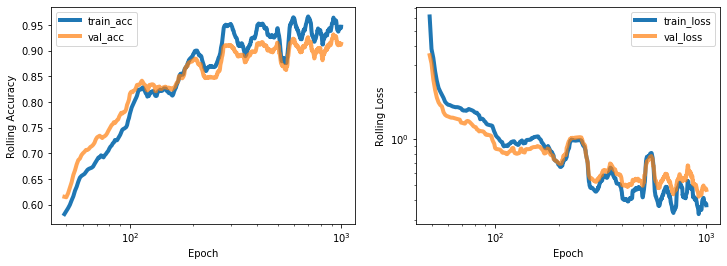

In [54]:
plot_accuracy_loss_rolling(wine_trained_l2, rollNum=50)

# Break Out Room 2

#### Recall from Section 9 that we had overfit to the Iris dataset
1. Run the given code below to overfit to the Iris dataset (this is the same as in Section 9)
2. Regularize the neural network on the Iris dataset. Tip: The regularization coefficient should be in the range 0.01 - 0.05 
3. Plot the accuracy and losses

Note: Use the functions we've declared above for plotting the loss and the neural network output

In [6]:
from sklearn import datasets

iris_data = datasets.load_iris()
X = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
y = pd.DataFrame(data=iris_data.target, columns=['species'])


In [12]:
%%time
# Increase the size of the testing set to encourage overfitting 
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X, y, test_size=0.6, 
                                                    random_state=41)


model_iris_ofit = models.Sequential([
  layers.Input(shape = (4,)),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(3, activation = 'softmax')
])
model_iris_ofit.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(0.005),
    metrics=['accuracy'],
)

##################
# TRAIN THE MODEL
##################
iris_trained_ofit = model_iris_ofit.fit(
    x = X_train_iris.to_numpy(), y = y_train_iris.to_numpy(), verbose=0,
    epochs=1000, validation_data= (X_test_iris.to_numpy(), y_test_iris.to_numpy()),
)


CPU times: user 42.4 s, sys: 2.26 s, total: 44.6 s
Wall time: 45.9 s


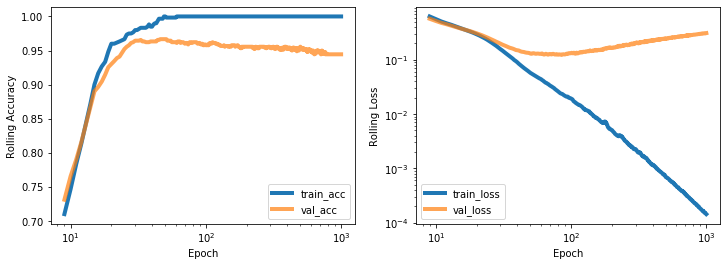

In [13]:
plot_accuracy_loss_rolling(iris_trained_ofit)

### Now regularize the network to reduce overfitting to Iris dataset

In [58]:
#your code here

In [16]:
# %load '../solutions/sol_2.py'


In [17]:
# %load '../solutions/sol_2b.py'



----------




## End of Section

----------